# Mamba на пальцах: реализация

Автор: Наказненко Павел

### DISCLAIMER:

В этой тетрадке представлены не самые удачные решения в плане эффективности и красоты написания кода, т.к. я прежде всего стремился к наглядности.
Я постарался построить код так, чтобы имлпементация делалась пошагово, сверху вниз, от общего к частному.
Например, я не вводил dataclass для аргументов модели, а так же пришлось сделать аргументами классы, которые еще не определены.
В продакшене можно (и нужно) красивее и оптимальнее, см. [оригинальную имплементацию](https://github.com/state-spaces/mamba) и [минималистичную версию](https://github.com/johnma2006/mamba-minimal)
Короче, не обессудьте.

In [ ]:
!pip install wandb

# Часть 1. Пишем Мамбу

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

Будем писать [Мамбу](https://arxiv.org/ftp/arxiv/papers/2312/2312.00752.pdf) "сверху вниз".

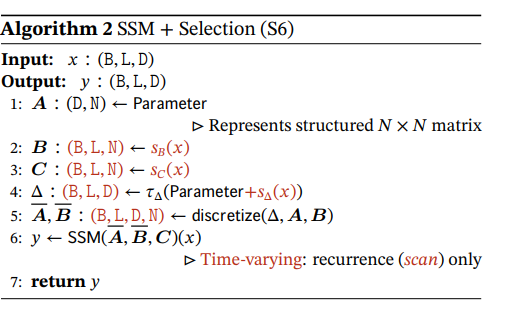

Коэфициент _E_ - коэфициент расширения размерности скрытого состояния. Он используется для увеличения размерности модели. Это позволяет расширить размер скрытых состояний модели, что потенциально улучшает её способность обучаться и представлять сложные закономерности в данных.

_R_ - гиперпараметр репараметризации для перехода от размерности 1 к размерности R:

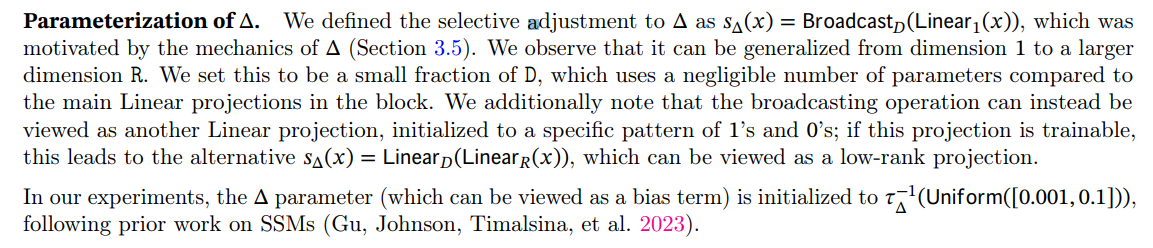

А так же обозначим сам класс Мамбы и в последствии реализуем каждый ее компонент. 

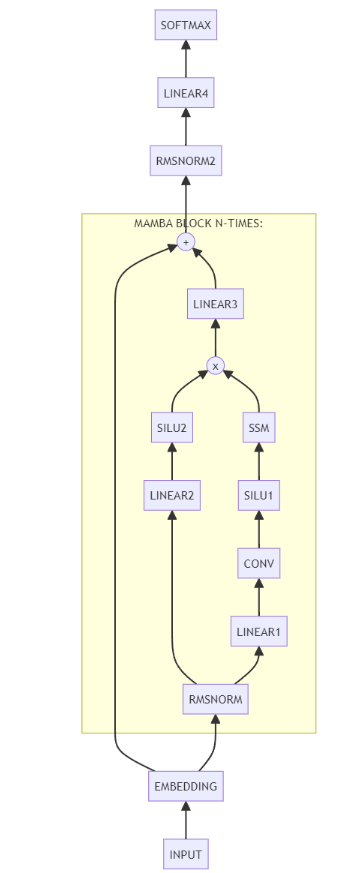

In [2]:
class Mamba(nn.Module):
    def __init__(self,
                        hidden_dim: int, # размерность скрытого представления
                        num_layers: int, # количество слоев
                        vocab_size: int, # размер словаря
                        normalization_cls = None, # класс, который будет использоваться для нормализации. Чуть позже это будет RMSNorm
                        layer_cls = None, # класс, который будет использоваться в качестве слоя. Чуть позже это будет ResidualBlock
                        pad_vocab_size_multiple: int = 8, # чему должен быть кратен размер словаря
):
        super().__init__()
        # делаем размер словаря кратным pad_vocab_size_multiple
        self.vocab_size = math.ceil(vocab_size / pad_vocab_size_multiple) * pad_vocab_size_multiple        

        self.norm = normalization_cls(hidden_dim)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.mamba_layers = nn.ModuleList([layer_cls(hidden_dim) for _ in range(num_layers)])

        self.lm_head = nn.Linear(hidden_dim, vocab_size, bias=False)
        # связываем веса, экономя память, время тренировки и улучшая качество представляение
        # подробнее тут https://arxiv.org/pdf/1608.05859v3.pdf
        self.lm_head.weight = self.embedding.weight   

    def forward(self, input_ids):
        # получаем embeddings
        x = self.embedding(input_ids)

        # прогоняем через слоим мамбы
        for layer in self.mamba_layers:
            x = layer(x)

        # нормализуем
        x = self.norm(x)

        # проецируем и получаем логиты
        logits = self.lm_head(x)

        return logits

Теперь реализуем каждый блок. Начнем с простого: root mean square norm

In [3]:
class RMSNorm(nn.Module):
    def __init__(self, hidden_dim, eps=1e-8):
        super(RMSNorm, self).__init__()
        self.hidden_dim = hidden_dim
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(hidden_dim))

    def forward(self, x):
        """ 
        На входе получаем тензор (batch_size, seq_length, hidden_dim)
        На выходе - такой же тензор, но нормализованный
        Как и почему работает читаем здесь: https://arxiv.org/pdf/1910.07467.pdf
        """
        # считаем root mean square
        rms = torch.sqrt(torch.mean(x**2, dim=-1, keepdim=True) + self.eps)
        # нормализуем с learnable scale
        x = x / rms * self.scale
        return x

Далее реализуем блок, который поддерживает Residual связи 

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim: int, **kwargs):
        """Обертка для блока мамбы с residual связью и RMSNorm"""
        super().__init__()
        self.mamba = MambaBlock(hidden_dim)
        self.norm = RMSNorm(hidden_dim)
        

    def forward(self, x):
        """
        На входе получаем тензор (batch_size, seq_length, hidden_dim)
        На выходе тензор такого же размера
        """
        # нормализуем
        output = self.norm(x)

        # прогоняем через мамбу
        output = self.mamba(output)

        # добавляем residual connection
        output += x

        return output

Ну а теперь самая мякотка: MambaBlock

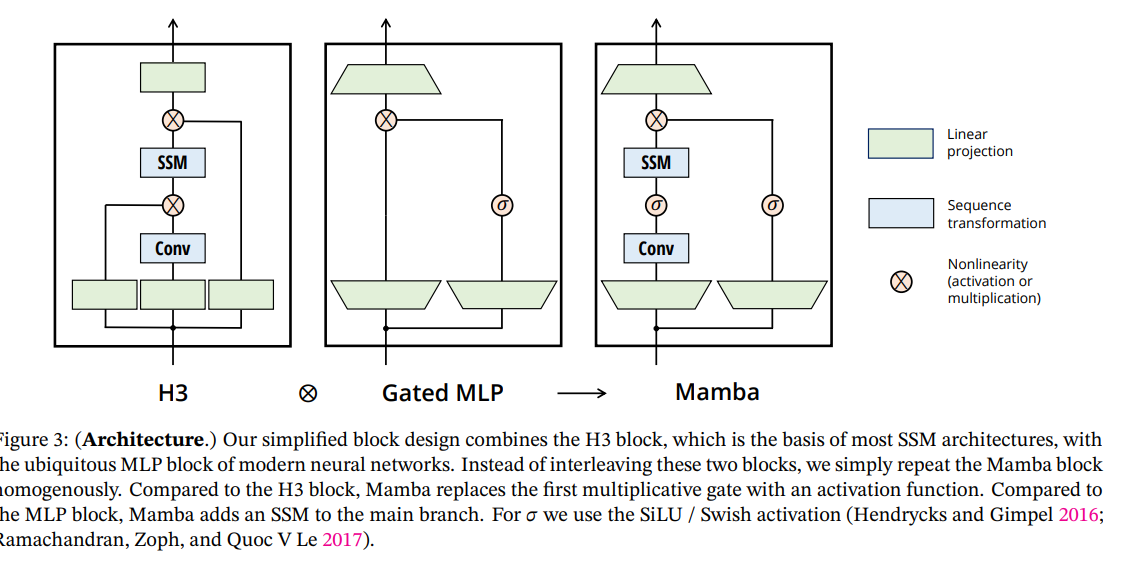

и алгоримт SSM 

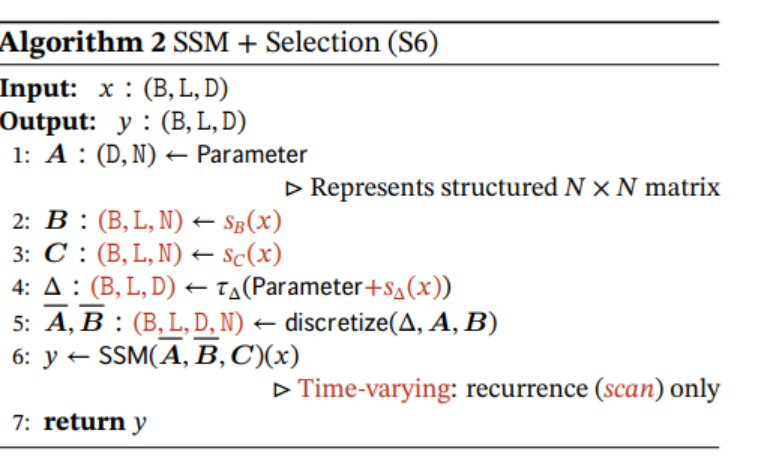

In [5]:
class MambaBlock(nn.Module):
    def __init__(self, 
                        hidden_dim: int, # размерность скрытого представления
                        kernel_size: int = 128, # размер ядра свертки    
                        latent_state_dim: int = 64, # размерность латентного состояния
                        E: int = 2, # expansion factor для hidden_dim, см раздел 3.4 статьи
                        R: int = 48, # размерность для репараметризации, см. раздел 3.6 статьи    
                        
                        conv_bias: bool = True, # нужен ли bias для сверточных слоев
                        proj_bias: bool = False, # нужен ли bias для слоев проецкии
                 ):
        super().__init__()
        
        # расширяем размерность скрытого представления (это параметр D в статье)
        self.hidden_dim_expanded = E * hidden_dim
        self.R = R
        self.latent_state_dim = latent_state_dim
        self.kernel_size = kernel_size
        
        # слой проекции вовнутрь
        self.in_proj = nn.Linear(hidden_dim, self.hidden_dim_expanded * 2, bias=proj_bias)
        
        # сверточный слой
        self.conv1d = nn.Conv1d(
            in_channels=self.hidden_dim_expanded,
            out_channels=self.hidden_dim_expanded,
            bias=conv_bias,
            kernel_size=kernel_size,
            groups=self.hidden_dim_expanded,
            padding=kernel_size - 1,
        )

        # x_proj проецирует `x` и выдает Δ, B и C соответствующие входу
        self.x_proj = nn.Linear(self.hidden_dim_expanded, R + latent_state_dim * 2, bias=False)
        
        # dt_proj проецирует Δ из R в hidden_dim_expanded
        self.dt_proj = nn.Linear(R, self.hidden_dim_expanded, bias=True)

        # создаем 1D тензор со значениями от 1 до latent_state_dim
        sequence = torch.arange(1, latent_state_dim + 1)
        # делаем из последовательности 2D тензор в котором hidden_dim_expanded строк повторений
        A = sequence.unsqueeze(0).repeat(self.hidden_dim_expanded, 1)
        
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(self.hidden_dim_expanded))
        self.out_proj = nn.Linear(self.hidden_dim_expanded, hidden_dim, bias=proj_bias)
        

    def forward(self, x):
        """
        На входе получаем тензор (batch_size, seq_length, hidden_dim)
        На выходе тензор того же размера
        """
        (batch_size, seq_length, hidden_dim) = x.shape

        # проецируем в x и residual часть 
        # (batch_size, seq_length, hidden_dim) -> (batch_size, seq_length, 2 * hidden_dim)
        x_and_residual = self.in_proj(x)
        
        (x, residual) = x_and_residual.split(split_size=[self.hidden_dim_expanded, self.hidden_dim_expanded], dim=-1)

        # меняем местами измерения тензоров (batch_size, seq_length, hidden_dim_expanded) -> (batch, hidden_dim_expanded, seq_length)
        x = x.permute(0, 2, 1)
        
        # применяем свертку и обрезаем на всякий случай по seq_length
        x = self.conv1d(x)[:, :, :seq_length]
        
        # меняем местами измерения тензоров к изначальному порядку
        x = x.permute(0, 2, 1)

        # применяем функцию активации
        x = F.silu(x)

        # применяем ssm
        y = self.ssm(x)

        # смешиваем с residual после активации 
        y = y * F.silu(residual)

        # проецируем вывод наружу (batch_size, seq_length, hidden_dim_expanded) -> (batch_size, seq_length, hidden_dim)
        output = self.out_proj(y)

        return output

    
    def ssm(self, x):
        """
            На входе получаем тензор (batch_size, seq_length, hidden_dim_expanded)
            На выходе тензор того же размера
        """
        # считаем state space параметры delta, A, B, C, и D
        #     A, D не зависят от входа (см. 3.5.2 "Interpretation of A" почему)
        #     delta, B, C зависят от входа, что и является новшеством Mamba по отношению к time invariant S4,
        #                                  и поэтому Mamba называется selective state spaces (S6)
        
        A = -torch.exp(self.A_log.float())  # shape (hidden_dim_expanded, latent_state_dim)
        D = self.D.float()

        # проецируем и получаем конкатенириованные delta, B, C
        x_cat = self.x_proj(x)  # (batch_size, seq_length, R + 2*n)

        # разбиваем x_cat на
        # delta: (batch_size, seq_length, R)
        # B: (batch_size, seq_length, n)
        # C: (batch_size, seq_length, n)
        (delta, B, C) = x_cat.split(split_size=[self.R, self.latent_state_dim, self.latent_state_dim], dim=-1)  

        # проецируем delta из R в hidden_dim_expanded
        # и активируем мягким relu (softplus)
        # (batch_size, seq_length, hidden_dim_expanded)
        delta = F.softplus(self.dt_proj(delta))

        # теперь делаем selective scan
        y = self.selective_scan(x, delta, A, B, C, D)
        
        return y

    
    def selective_scan(self, u, delta, A, B, C, D):
        """Реализация selective scan алгоритма. См:
            - Section 2 State Space Models
            - Algorithm 2 in Section 3.2
            - run_SSM(A, B, C, u) в The Annotated S4 https://srush.github.io/annotated-s4/

        Классическая discrete state space формула:
            x(t + 1) = Ax(t) + Bu(t)
            y(t)     = Cx(t) + Du(t)
        с той лишь разницей, что B и C (а также размер шага delta, который используется для дискретизации) зависят от входа x(t).
    
        На входе:
            u: shape (batch_size, seq_length, hidden_dim_expanded)
            delta: shape (batch_size, seq_length, hidden_dim_expanded)
            A: shape (hidden_dim_expanded, latent_state_dim)
            B: shape (batch_size, seq_length, latent_state_dim)
            C: shape (batch_size, seq_length, latent_state_dim)
            D: shape (hidden_dim_expanded,)
    
        На выходе:
            output: shape (batch_size, seq_length, hidden_dim_expanded)    
        """
        (batch_size, seq_length, hidden_dim_expanded) = u.shape
        
        # дискретизируем непрерывные параметры A и B
        # - A дискретизируется с помощью метода zero-order hold (ZOH) (https://en.wikipedia.org/wiki/Zero-order_hold)
        # - B дискретизируется с помощью упрощенной дискретизации Эйлера. Т.к. согласно авторам:
        #   "Параметр A является более важным и сеть работает не сильно хуже, если считать параметр В упрощенным методом"
        deltaA = torch.exp(torch.einsum('b l d, d n -> b l d n', delta, A))
    
        # вычисляем произведения delta * B * u для каждого шага времени
        deltaB_u = torch.einsum('b l d, b l n, b l d -> b l d n', delta, B, u)
    
        # инициализируем состояния x и списка для хранения выходных значений y
        x = torch.zeros((batch_size, hidden_dim_expanded, self.latent_state_dim), device=deltaA.device)
        ys = []
    
        # пробегаемся по всей последовательности
        for i in range(seq_length):
            # обновляем состояние x с использованием текущего значения deltaA и deltaB_u
            x = deltaA[:, i] * x + deltaB_u[:, i]
    
            # вычисляем выходное значение y на текущем шаге
            y = torch.einsum('b d n, b n -> b d', x, C[:, i, :])
    
            # добавляем текущее значение y в список
            ys.append(y)
    
        # собираем все выходные значения y в один тензор
        y = torch.stack(ys, dim=1)
    
        # добавляем влияние входного сигнала u, умноженного на D, к каждому элементу выходного тензора y
        y = y + u * D
    
        return y

Фух! Отлично, мы справились. Теперь давайте потренируемся на ~~котиках~~ MNIST.

# Часть 2. Тренируем на MNIST

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb
import numpy as np
import matplotlib.pyplot as plt

In [27]:
SIDE = 14 # размер стороны изображения в пикселях

In [28]:
# подготавливаем датасет и меня размер изображений (иначе состариться можно, пока оно дотренируется)
transform = transforms.Compose([transforms.Resize((SIDE, SIDE)), transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Сделаем свой трансформер-декодер на минималках с RoPE энкодером для позиций. Будем решать задачу предсказания пикселей (256 классов) в авторегрессионной манере этим трансформером и мамбой.

In [29]:
import math

class RoPEPositionalEncoding(nn.Module):
    """
    RoPE кодировщик для позиции токена
    Подробности реализации см. тут https://arxiv.org/abs/2104.09864v5
    """
    def __init__(self, d_model, max_len=SIDE*SIDE):
        super(RoPEPositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        pe = self.pe[:seq_len, :].unsqueeze(0)
        return x + pe

class CausalTransformer(nn.Module):
    """
    Классический трансформер-декодер, с каузальной маской и RoPE
    """
    def __init__(self, input_size, d_model, nhead, num_layers, num_classes):
        super(CausalTransformer, self).__init__()
        # слой эмбеддинга токенов (пикселей). 
        # Да, да, я понимаю, что это избыточно и маразм, что можно использовать значения самих пикселей
        # но мы тут притворяемся на игрушечной, нагялдной задаче, будто бы текст предсказываем.
        self.embedding = nn.Embedding(input_size, d_model)

        # слой энкодер позиции токенов (пикселей)
        self.pos_encoder = RoPEPositionalEncoding(d_model)

        # трансформер декодер
        transformer_decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(transformer_decoder_layer, num_layers)

        # голова
        self.fc_out = nn.Linear(d_model, num_classes)
        
    def generate_attention_mask(self, sz):
        """
        Генерируем матрицу каузальности
        """
        # перем матрицу из единиц и получаем маску всех элементов ниже главной диагонали
        mask = (torch.tril(torch.ones(sz, sz)) == 1)     
        # строим causal attention mask
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        # получаем эмбеддинги последовательнсоти
        x = self.embedding(x)

        # добавляем позицию к эмбеддингу
        x = self.pos_encoder(x)

        # считаем causal attention mask
        tgt_mask = self.generate_attention_mask(x.size(1)).to(x.device)

        # пропускаем через слои трансформера
        x = self.transformer_decoder(x, x, tgt_mask)

        # возращаем результат головы
        return self.fc_out(x)

In [30]:
# гиперпараметры
hidden_size = 64 # размер скрытого пространства
num_layers = 2 # количество слоев
num_heads = 4 # количество голов (для трансформера)
num_classes = 256 # размерность нашего "словаря"
learning_rate = 0.0001
num_epochs = 10

In [31]:
# бейзлайн модель с трансформером
model_transformer = CausalTransformer(num_classes, hidden_size, num_heads, num_layers, num_classes)
criterion_transformer = nn.CrossEntropyLoss()
optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=learning_rate)

In [32]:
# испытуемая модель мамбы
model_mamba = Mamba(
    hidden_dim = hidden_size,
    num_layers = num_layers,
    vocab_size = num_classes,
    normalization_cls = RMSNorm,
    layer_cls = ResidualBlock,
    pad_vocab_size_multiple = 8)
criterion_mamba = nn.CrossEntropyLoss()
optimizer_mamba = optim.Adam(model_mamba.parameters(), lr=learning_rate)

In [33]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import OneCycleLR

def train(model, loader, criterion, optimizer, device, run_name):
    wandb.init(project="mnist_pixel_prediction", name=run_name)
    model.train()

    scheduler = OneCycleLR(optimizer, 
                           max_lr = 0.0001,
                           steps_per_epoch = len(loader),
                           epochs = num_epochs,
                           anneal_strategy = 'cos')

    for epoch in tqdm(range(num_epochs), desc="Epoch"):
        pbar = tqdm(loader, desc="Batch")
        for images, _ in pbar:
            images = images.to(device)

            images = images.view(images.size(0), -1, 1)
            targets = images.view(images.size(0), -1)

            # здесь считаем лосс как при language modelling, т.е.
            # на сколько ошиблись с предсказанием каждого токена
            targets = torch.floor(targets*255).long()[:, 1:]  
            images = torch.floor(images*255).long()[:, :-1, :]

            outputs = model(images.view(images.shape[0], -1))

            y_true = targets.contiguous().view(-1)
            y_pred = outputs.contiguous().view(-1, num_classes)
            
            loss = criterion(y_pred, y_true)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            wandb.log({"loss": loss.item(), "learning_rate": optimizer.param_groups[0]['lr']})
            pbar.set_postfix({"loss": loss.item()})
            
            scheduler.step()
    wandb.finish()

In [34]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Eval batch"):
            images = images.to(device)
            images = images.view(images.size(0), -1, 1)
            targets = images.view(images.size(0), -1)

            # здесь считаем лосс как при language modelling, т.е.
            # на сколько ошиблись с предсказанием каждого токена
            targets = torch.floor(targets*255).long()[:, 1:]
            images = torch.floor(images*255).long()[:, :-1, :]
            
            outputs = model(images.view(images.shape[0], -1))

            y_true = targets.contiguous().view(-1)
            y_pred = outputs.contiguous().view(-1, num_classes)

            loss = criterion(y_pred, y_true)
            
            total_loss += loss.item()
    
    return total_loss / len(loader)

In [35]:
def visualize_predictions(model, loader, device, num_samples=4):
    """
    Вспомогательная функции визуализации предсказаний по первой половине пикселей
    """
    model.eval()
    images, _ = next(iter(loader))
    images = images[:num_samples].to(device)
    original_images = images.view(images.size(0), -1, 1)
    predicted_images = torch.zeros_like(original_images)
    predicted_images[:, :original_images.size(1) // 2] = original_images[:, :original_images.size(1) // 2]
    predicted_images = torch.floor(predicted_images*255).long()
    print(f"{original_images.shape=} {predicted_images.shape=}")
    with torch.no_grad():
        for i in range(original_images.size(1) // 2, original_images.size(1)):            
            outputs = model(predicted_images[:, :i].view(predicted_images.shape[0], -1))
            predicted_pixels = outputs[:, i-1].argmax(dim=1)
            predicted_images[:, i] = predicted_pixels.unsqueeze(-1).long()

    original_images = original_images.view(num_samples, SIDE, SIDE).cpu().numpy()
    predicted_images = predicted_images.view(num_samples, SIDE, SIDE).cpu().numpy()

    fig, axs = plt.subplots(2, num_samples, figsize=(10, 4))
    for i in range(num_samples):
        axs[0, i].imshow(original_images[i], cmap='gray')
        axs[1, i].imshow(predicted_images[i], cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    plt.show()

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mamba = model_mamba.to(device)
model_transformer = model_transformer.to(device)
model_mamba, model_transformer

(Mamba(
   (norm): RMSNorm()
   (embedding): Embedding(256, 64)
   (mamba_layers): ModuleList(
     (0-1): 2 x ResidualBlock(
       (mamba): MambaBlock(
         (in_proj): Linear(in_features=64, out_features=256, bias=False)
         (conv1d): Conv1d(128, 128, kernel_size=(128,), stride=(1,), padding=(127,), groups=128)
         (x_proj): Linear(in_features=128, out_features=176, bias=False)
         (dt_proj): Linear(in_features=48, out_features=128, bias=True)
         (out_proj): Linear(in_features=128, out_features=64, bias=False)
       )
       (norm): RMSNorm()
     )
   )
   (lm_head): Linear(in_features=64, out_features=256, bias=False)
 ),
 CausalTransformer(
   (embedding): Embedding(256, 64)
   (pos_encoder): RoPEPositionalEncoding()
   (transformer_decoder): TransformerDecoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerDecoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=

original_images.shape=torch.Size([4, 196, 1]) predicted_images.shape=torch.Size([4, 196, 1])


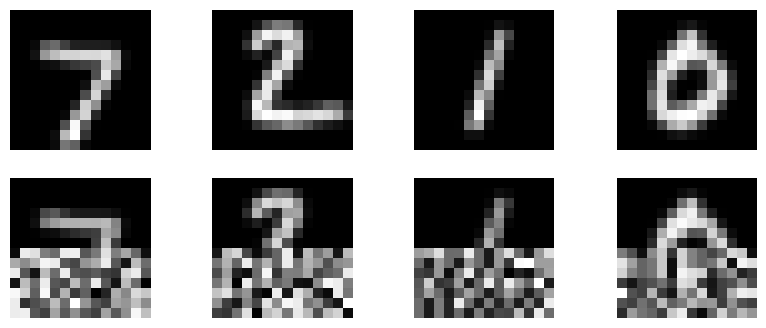

In [37]:
# смотрим чего у нас выводит трансформер до тренировки
visualize_predictions(model_transformer, test_loader, device)

original_images.shape=torch.Size([4, 196, 1]) predicted_images.shape=torch.Size([4, 196, 1])


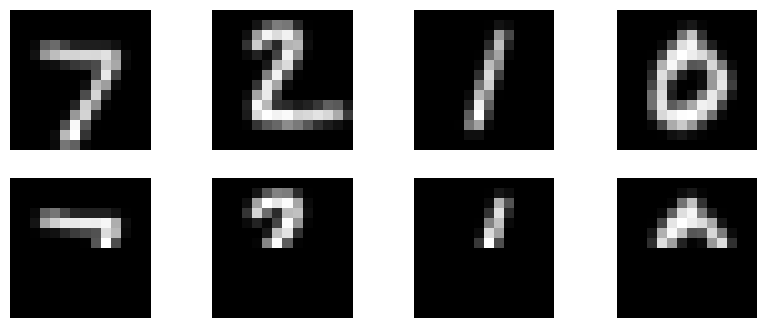

In [38]:
# смотрим чего у нас выводит мамба до тренировки
visualize_predictions(model_mamba, test_loader, device)

In [ ]:
# сначала тренируем бейзалйн (трансформер)
train(model_transformer, train_loader, criterion_transformer, optimizer_transformer, device, "mnist_transformer")

In [ ]:
# теперь тренируем мамбу (это будет гораздо медленнее, чем трансформер, потому что у нас наиваная имплементация)
train(model_mamba, train_loader, criterion_mamba, optimizer_mamba, device, "mnist_mamba")

## Результаты

Предсказания трансформера:

Eval batch:   0%|          | 0/2500 [00:00<?, ?it/s]

Transformer Validation Loss: 1.3570680759429932
original_images.shape=torch.Size([4, 196, 1]) predicted_images.shape=torch.Size([4, 196, 1])


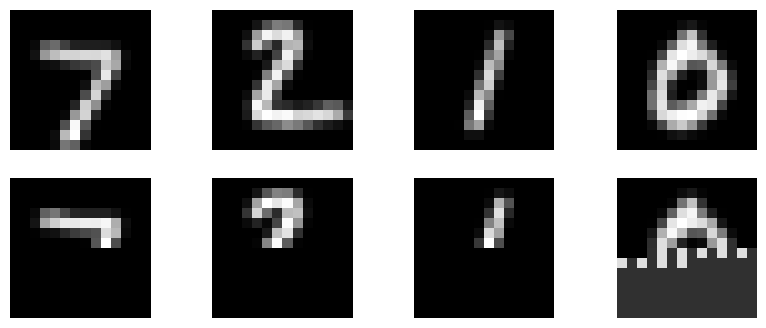

In [49]:
val_loss = evaluate(model_transformer, test_loader, criterion_transformer, device)
print("Transformer Validation Loss:", val_loss)
visualize_predictions(model_transformer, test_loader, device)

Предсказания мамбы:

Eval batch:   0%|          | 0/2500 [00:00<?, ?it/s]

Mamba Validation Loss: 1.4693889768600463
original_images.shape=torch.Size([4, 196, 1]) predicted_images.shape=torch.Size([4, 196, 1])


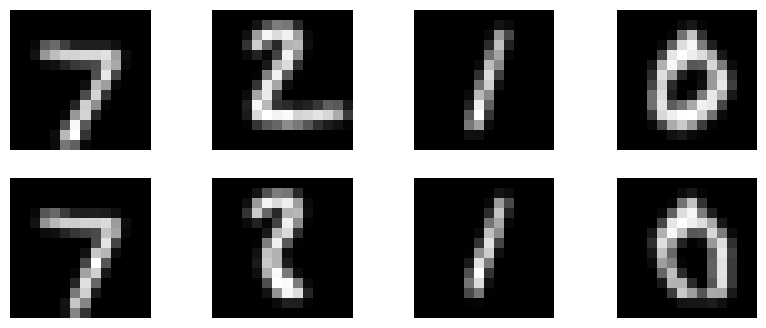

In [48]:
val_loss = evaluate(model_mamba, test_loader, criterion_mamba, device)
print("Mamba Validation Loss:", val_loss)
visualize_predictions(model_mamba, test_loader, device)

Графики ~~жирафики~~ loss:

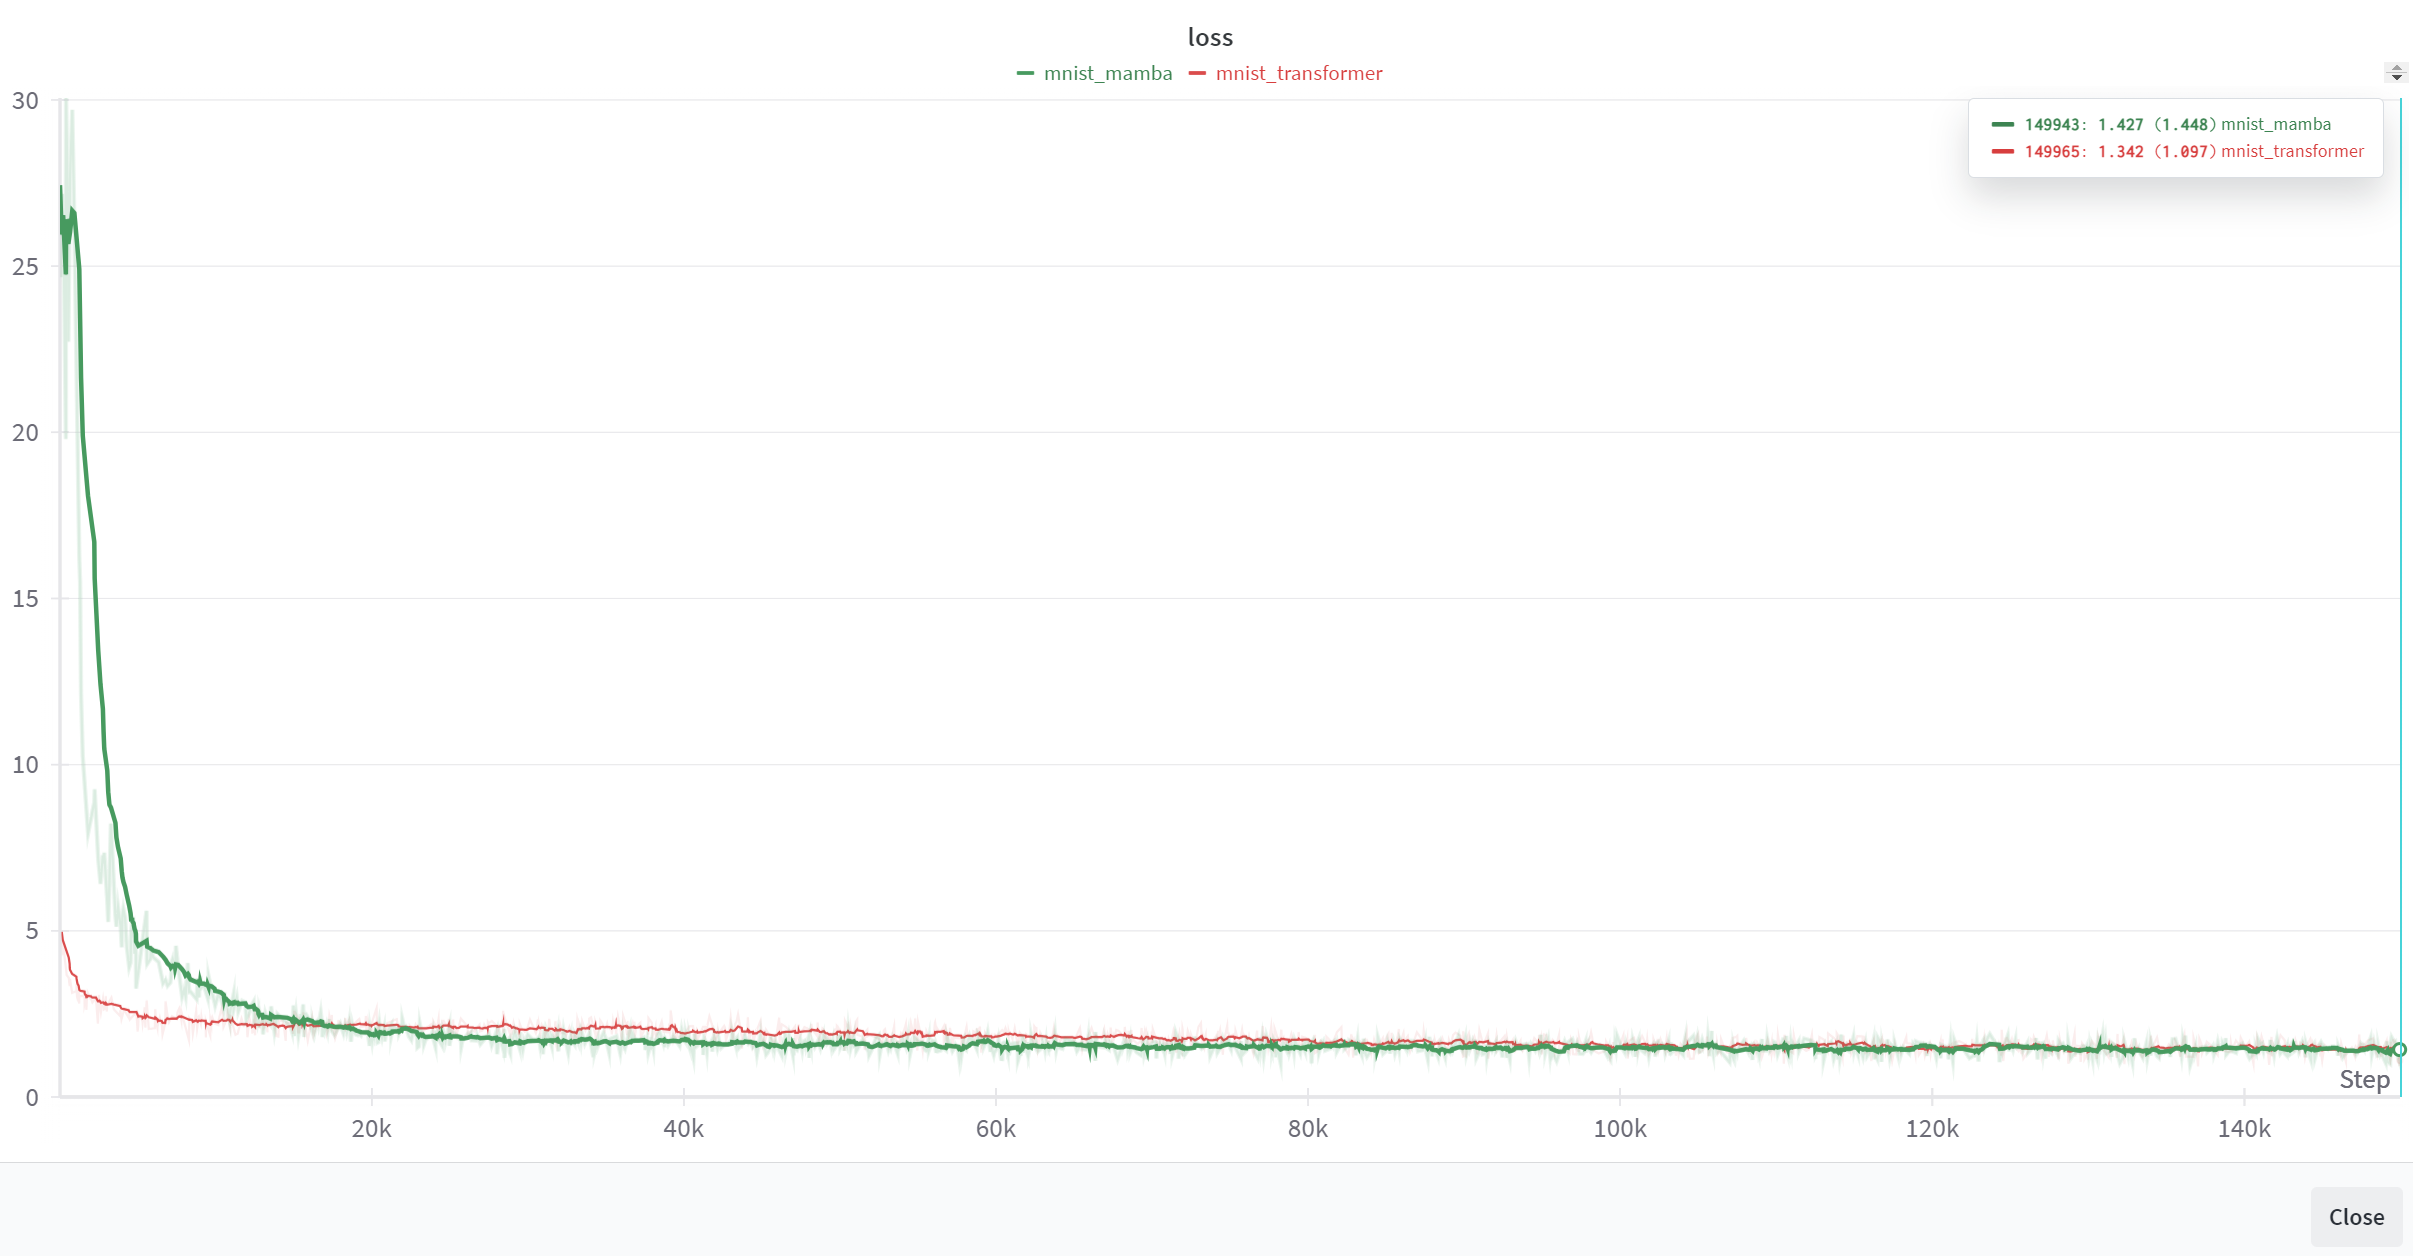

# Вы великолепны!